# Import Library


In [33]:
import gc
import os
import random
import time
import wandb
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.transforms import Compose
from torchmetrics.functional.image import structural_similarity_index_measure as ssim

# Data Preparation

In [34]:
class DF2KDataset(Dataset):
    def __init__(self, hr_images_path, random_crop:bool=True, transforms:Compose=None, output_size:tuple=(256, 256), seed:int=1989):
        super(DF2KDataset, self).__init__()
        
        self.hr_images_path = hr_images_path
        
        hr_images_list = os.listdir(hr_images_path)
        
        self.hr_images_list = [hr_images_path + image_name for image_name in hr_images_list]
        
        self.random_crop = random_crop
        self.transforms = transforms
        self.output_size = output_size
        self.seed = seed
    
    def __getitem__(self, idx):
        hr_image_path = self.hr_images_list[idx]
        lr_image_path = hr_image_path.replace('.png', 'x4.png').replace('HR', 'LR_bicubic/X4')
        
        hr_image = Image.open(hr_image_path)
        lr_image = Image.open(lr_image_path)
        
        # -------------------- RANDOM CROP -------------------- #
        if self.random_crop:
            w, h = hr_image.size
            th, tw = self.output_size
            random.seed(self.seed + idx)
            i = random.choice(list(range(0, h-th+1, 4)))
            j = random.choice(list(range(0, w-tw+1, 4)))

            hr_image = transforms.functional.crop(hr_image, i, j, th, tw)
            lr_image = transforms.functional.crop(lr_image, i//4, j//4, th//4, tw//4)
        
        # -------------------- OTHER TRANSFORMATIONS -------------------- #
        if self.transforms:
            torch.manual_seed(seed=self.seed)
            hr_image = self.transforms(hr_image)
            torch.manual_seed(seed=self.seed)
            lr_image = self.transforms(lr_image)
            
        # -------------------- TO TENSOR -------------------- #
        hr_image = transforms.functional.to_tensor(hr_image)
        lr_image = transforms.functional.to_tensor(lr_image)
        
        return hr_image, lr_image
        
    def __len__(self):
        return len(self.hr_images_list)

In [35]:
class DF2KDataLoader(DataLoader):
    def __init__(self, hr_images_path, 
                 random_crop:bool=True, transforms:Compose=None, output_size:tuple=(256, 256), seed:int=1989,
                 batch_size:int=1, shuffle:bool=True, num_crops:int=1):
        """
        - hr_images_path: str
            Path to the high-resolution images
        - random_crop: bool
            Whether to crop the images. Default is True. You might want to crop on the training set, but not on the validation set.
        - transforms: Compose
            A Compose of transformations, applied similarly on both high-res and low-res images.
            >> NOTE: Some transformations might worsen the quality of image, so consider carefully.
        - output_size: tuple
            Size of the random crop applied to an image. Default is 256x256.
            >> NOTE: Only meaningful when `random_crop` is True.
        - seed: int
            A random number, meant to keep all transformations the same for high-res and low-res images
        - num_crops: int
            The number of random crops applied to an image. Size of dataset is multiplied accordingly. Default is 1.
            >> NOTE: Only meaningful when `random_crop` is True.
        """
        if random_crop and num_crops > 1:
            random.seed(1989)
            sub_datasets = [DF2KDataset(hr_images_path, random_crop=random_crop, transforms=transforms, output_size=output_size, seed=seed+int(random.random()*10)) 
                            for _ in range(num_crops)]
            self.dataset = ConcatDataset(sub_datasets)
        else:
            self.dataset = DF2KDataset(hr_images_path, random_crop=random_crop, transforms=transforms, output_size=output_size, seed=seed)
        super().__init__(self.dataset, batch_size=batch_size, shuffle=shuffle)

In [36]:
HR_IMAGES_PATH_TRAIN = "/kaggle/input/df2kdata/DF2K_train_HR/"
HR_IMAGES_PATH_VALID = "/kaggle/input/df2kdata/DF2K_valid_HR/"

class RandomRotation(object):
    def __call__(self, img):
        rotation_angle = torch.randint(0, 3, (1,)).item() * 90

        return transforms.functional.rotate(img, rotation_angle)

TRANSFORMS = Compose([
    transforms.RandomHorizontalFlip(),
    RandomRotation()
])

train_dataloader = DF2KDataLoader(
    hr_images_path=HR_IMAGES_PATH_TRAIN,
    random_crop=True,
    transforms=TRANSFORMS,
    output_size=(192, 192),
    seed=1989,
    batch_size=32,
    shuffle=True,
    num_crops=2
)

valid_dataloader = DF2KDataLoader(
    hr_images_path=HR_IMAGES_PATH_VALID,
    random_crop=False,
    transforms=None,
    seed=1989,
    batch_size=1,
    shuffle=False
)

Length of train_dataloader: 216
>> Size of high-res image: torch.Size([192, 192, 3])
>> Size of low-res image: torch.Size([48, 48, 3])


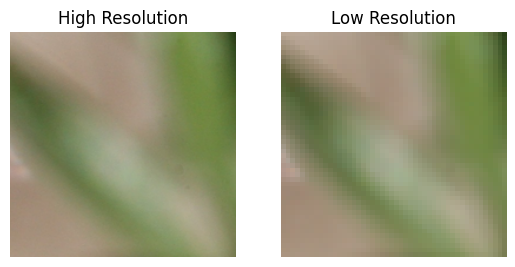

In [37]:
print("Length of train_dataloader: {}".format(len(train_dataloader)))
hrs, lrs = next(iter(train_dataloader))

hr = hrs[0].permute((1, 2, 0))
lr = lrs[0].permute((1, 2, 0))

print(">> Size of high-res image:", hr.size())
print(">> Size of low-res image:", lr.size())
fig, axs = plt.subplots(1, 2)

axs[0].imshow(hr)
axs[0].set_title('High Resolution')
axs[1].imshow(lr)
axs[1].set_title('Low Resolution')

for ax in axs.flat:
    ax.axis('off')

plt.show()

# Model Architecture

In [38]:
# ------------------------------ HYPERPARAMS ------------------------------ #
NUM_RESIDUAL_GROUPS = 8
NUM_RESIDUAL_BLOCKS = 16
KERNEL_SIZE = 3
REDUCTION_RATIO = 16
NUM_CHANNELS = 64
UPSCALE_FACTOR = 4

In [39]:
class ResidualChannelAttentionBlock(nn.Module):
    def __init__(self, num_channels=NUM_CHANNELS, reduction_ratio=REDUCTION_RATIO, kernel_size=KERNEL_SIZE):
        
        super(ResidualChannelAttentionBlock, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(num_channels, num_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(num_channels, num_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        )

        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(num_channels, num_channels//reduction_ratio, kernel_size=1, stride=1),
            nn.ReLU(),
            # nn.BatchNorm2d(num_channels//reduction_ratio),
            nn.Conv2d(num_channels//reduction_ratio, num_channels, kernel_size=1, stride=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        block_input = x.clone()

        residual = self.feature_extractor(x) # Feature extraction
        rescale = self.channel_attention(residual) # Rescaling vector
        
        block_output = block_input + (residual * rescale)
        
        return block_output

In [40]:
class ResidualGroup(nn.Module):
    def __init__(self, num_residual_blocks=NUM_RESIDUAL_BLOCKS,
                 num_channels=NUM_CHANNELS, reduction_ratio=REDUCTION_RATIO, kernel_size=KERNEL_SIZE):
        
        super(ResidualGroup, self).__init__()

        self.residual_blocks = nn.Sequential(
            *[ResidualChannelAttentionBlock(num_channels=num_channels, reduction_ratio=reduction_ratio, kernel_size=kernel_size) 
              for _ in range(num_residual_blocks)]
        )

        self.final_conv = nn.Conv2d(num_channels, num_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
    
    def forward(self, x):
        group_input = x.clone()

        residual = self.residual_blocks(x) # Residual blocks
        residual = self.final_conv(residual) # Final convolution

        group_output = group_input + residual

        return group_output

In [41]:
class ResidualInResidual(nn.Module):
    def __init__(self, num_residual_groups=NUM_RESIDUAL_GROUPS, num_residual_blocks=NUM_RESIDUAL_BLOCKS,
                 num_channels=NUM_CHANNELS, reduction_ratio=REDUCTION_RATIO, kernel_size=KERNEL_SIZE):
        
        super(ResidualInResidual, self).__init__()

        self.residual_groups = nn.Sequential(
            *[ResidualGroup(num_residual_blocks=num_residual_blocks,
                            num_channels=num_channels, reduction_ratio=reduction_ratio, kernel_size=kernel_size) 
              for _ in range(num_residual_groups)]
        )

        self.final_conv = nn.Conv2d(num_channels, num_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
    
    def forward(self, x):
        shallow_feature = x.clone()
        
        residual = self.residual_groups(x) # Residual groups
        residual = self.final_conv(residual) # Final convolution

        deep_feature = shallow_feature + residual

        return deep_feature

In [42]:
class RCAN(nn.Module):
    def __init__(self, num_residual_groups=NUM_RESIDUAL_GROUPS, num_residual_blocks=NUM_RESIDUAL_BLOCKS,
                 num_channels=NUM_CHANNELS, reduction_ratio=REDUCTION_RATIO, kernel_size=KERNEL_SIZE):
        
        super(RCAN, self).__init__()

        self.shallow_conv = nn.Conv2d(3, num_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.residual_in_residual = ResidualInResidual(num_residual_groups=num_residual_groups, num_residual_blocks=num_residual_blocks,
                                                       num_channels=num_channels, reduction_ratio=reduction_ratio, kernel_size=kernel_size)
        self.upscaling_module = nn.PixelShuffle(upscale_factor=UPSCALE_FACTOR)
        self.reconstruction_conv = nn.Conv2d(num_channels // (UPSCALE_FACTOR ** 2), 3, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
    
    def forward(self, x):
        shallow_feature = self.shallow_conv(x) # Initial convolution
        deep_feature = self.residual_in_residual(shallow_feature) # Residual in Residual
        upscaled_image = self.upscaling_module(deep_feature) # Upscaling module
        reconstructed_image = self.reconstruction_conv(upscaled_image) # Reconstruction

        return reconstructed_image

In [43]:
# ------------------------------ HYPERPARAMS ------------------------------ #
LR = 3e-4
BETAS = (0.9, 0.999)
EPS = 1e-8
STEP_SIZE = 10
GAMMA = 0.67

NUM_EPOCHS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [44]:
DEVICE

device(type='cuda')

In [45]:
class Network:
    def __init__(self, for_inference=False, train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,
                 lr=LR, betas=BETAS, eps=EPS, step_size=STEP_SIZE, gamma=GAMMA,
                 num_epochs=NUM_EPOCHS, device=DEVICE, run_id=None):
        
        self.for_inference = for_inference
        self.model = RCAN().to(device)
        self.device = device
        
        if not self.for_inference:
            self.loss_fn = nn.L1Loss().to(device)
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=betas, eps=eps)
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)

            self.train_dataloader = train_dataloader
            self.valid_dataloader = valid_dataloader
            self.num_epochs = num_epochs

            self.run_id = run_id
    
    def save_network(self, epoch, train_loss, valid_loss, checkpoint_path):
        checkpoint = {
            'epoch': epoch,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'learning_rate_scheduler': self.scheduler.state_dict(),
            'network': self
        }
        torch.save(checkpoint, checkpoint_path)

    def load_network(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model'])
        if not self.for_inference:
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.scheduler.load_state_dict(checkpoint['learning_rate_scheduler'])
        return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['valid_loss']

    def train_step(self, lr_images, hr_images):
        lr_images, hr_images = lr_images.to(self.device), hr_images.to(self.device)
        self.optimizer.zero_grad()
        sr_images = self.model(lr_images)
        loss = self.loss_fn(sr_images, hr_images)
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def valid_step(self, lr_images, hr_images):
        lr_images, hr_images = lr_images.to(self.device), hr_images.to(self.device)
        sr_images = self.model(lr_images)
        loss = self.loss_fn(sr_images, hr_images)
        return loss.item()
    
    def train_model(self):

        last_valid_loss = float('inf')
        wandb.init(project='rcan-for-image-sr',
                   resume='allow',
                   config={
                       'lr': LR,
                       'betas': BETAS,
                       'eps': EPS,
                       'step_size': STEP_SIZE,
                       'gamma': GAMMA,
                       'num_epochs': NUM_EPOCHS,
                       'num_residual_groups': NUM_RESIDUAL_GROUPS,
                       'num_residual_blocks': NUM_RESIDUAL_BLOCKS,
                       'kernel_size': KERNEL_SIZE,
                       'reduction_ratio': REDUCTION_RATIO,
                       'num_channels': NUM_CHANNELS,
                       'upscale_factor': UPSCALE_FACTOR
                   },
                   id=self.run_id)
        wandb.watch(self.model)

        for epoch in range(self.num_epochs):
            
            start = time.time()

            # ------------------- TRAIN -------------------
            self.model.train()
            train_epoch_loss = 0

            for hr_images, lr_images in tqdm(self.train_dataloader, desc=f'Epoch {epoch+1}/{self.num_epochs}'):
                loss = self.train_step(lr_images, hr_images)
                train_epoch_loss += loss
            
            del hr_images
            del lr_images
            gc.collect()
            torch.cuda.empty_cache()
            
            train_epoch_loss /= len(self.train_dataloader)

            end = time.time()

            # ------------------- VALID -------------------
            self.model.eval()
            with torch.no_grad():
                valid_epoch_loss = 0

                for hr_images, lr_images in tqdm(self.valid_dataloader, desc=f'Epoch {epoch+1}/{self.num_epochs}'):
                    loss = self.valid_step(lr_images, hr_images)
                    valid_epoch_loss += loss
                
                del hr_images
                del lr_images
                gc.collect()
                torch.cuda.empty_cache()
                
                valid_epoch_loss /= len(self.valid_dataloader)
            
            # ------------------- LOG -------------------
            wandb.log({
                'train_loss': train_epoch_loss,
                'valid_loss': valid_epoch_loss,
                'learning_rate': self.optimizer.param_groups[0]['lr']
            })
            self.scheduler.step()

            # ------------------- VERBOSE -------------------
            print(f'Epoch {epoch+1}/{self.num_epochs} | Train Loss: {train_epoch_loss:.4f} | Valid Loss: {valid_epoch_loss:.4f} | Time: {end-start:.2f}s')

            # ------------------- CHECKPOINT -------------------
            self.save_network(epoch, train_epoch_loss, valid_epoch_loss, 'model_checkpoint_latest.pth')
            if valid_epoch_loss < last_valid_loss:
                last_valid_loss = valid_epoch_loss
                self.save_network(epoch, train_epoch_loss, valid_epoch_loss, 'model_checkpoint_best.pth')
                print("New best checkpoint saved!")
        
        wandb.finish()
    
    def inference(self, lr_image, hr_image=None):
        """
        - lr_image: torch.Tensor
            3D Tensor (C, H, W)
        - hr_image: torch.Tesnor
            3D Tensor (C, H, W). This parameter is optional, for comparing the model output and the 
            ground-truth high-res image. If used solely for inference, skip this. Default is None/
        """
        lr_image = lr_image.unsqueeze(0).to(self.device)
        with torch.no_grad():
            sr_image = self.model(lr_image)
        
        lr_image = lr_image.squeeze(0)
        sr_image = sr_image.squeeze(0)
        
        print(">> Size of low-res image:", lr_image.size())
        print(">> Size of super-res image:", sr_image.size())
        if hr_image != None:
            print(">> Size of high-res image:", hr_image.size())
        
        if hr_image != None:
            fig, axes = plt.subplots(1, 3, figsize=(10, 6))
            axes[0].imshow(lr_image.cpu().detach().permute((1, 2, 0)))
            axes[0].set_title('Low Resolution')
            axes[1].imshow(sr_image.cpu().detach().permute((1, 2, 0)))
            axes[1].set_title('Super Resolution')
            axes[2].imshow(hr_image.cpu().detach().permute((1, 2, 0)))
            axes[2].set_title('High Resolution')
            for ax in axes.flat:
                ax.axis('off')
        else:
            fig, axes = plt.subplots(1, 2, figsize=(10, 6))
            axes[0].imshow(lr_image.cpu().detach().permute((1, 2, 0)))
            axes[0].set_title('Low Resolution')
            axes[1].imshow(sr_image.cpu().detach().permute((1, 2, 0)))
            axes[1].set_title('Super Resolution')
            for ax in axes.flat:
                ax.axis('off')
        
        plt.tight_layout()        
        plt.show()
        
        return sr_image    
    
    def train_model_continue(self, checkpoint_path):
        
        start_epoch, train_loss, valid_loss = self.load_network(checkpoint_path)
        print("Previous train loss: ", train_loss)
        print("Previous valid loss: ", valid_loss)
        print("------------------- Resuming training -------------------")
        self.num_epochs -= start_epoch
        self.train_model()

In [46]:
#rcan = Network(run_id='rcan-for-image-sr-19')
#num_params = sum(p.numel() for p in rcan.model.parameters() if p.requires_grad)
#print("Number of learnable parameters: ", num_params)

In [47]:
# rcan = torch.load('/kaggle/input/rcan-ultravision/model_checkpoint_latest.pth')
# rcan.optimizer = optim.Adam(rcan.model.parameters(), lr=1e-4, betas=BETAS, eps=EPS)
# rcan.scheduler = optim.lr_scheduler.StepLR(rcan.optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [48]:
#wandb.login(key='2239cd9d93e77db267b258d6da608bf2a7e5a516')


In [49]:
# rcan = Network(run_id='rcan-for-image-sr-20')
# rcan.train_model()

In [50]:
#net = Network(for_inference=True)
# net.train_model_continue('/kaggle/input/3rd-model/pytorch/default/1/model_checkpoint_latest.pth')


In [51]:
# torch.save(rcan, 'first_network.pth')

# Testset

In [52]:
class TestDataset(Dataset):
    def __init__(self, hr_images_path):
        super(TestDataset, self).__init__()
        hr_images_list = os.listdir(hr_images_path)
        self.hr_images_list = [hr_images_path + image_name for image_name in hr_images_list if image_name.endswith('HR.png')]
    
    def __getitem__(self, idx):
        hr_image_path = self.hr_images_list[idx]
        lr_image_path = hr_image_path.replace('HR', 'LR')
        
        hr_image = Image.open(hr_image_path)
        lr_image = Image.open(lr_image_path)
        
        hr_image = transforms.functional.to_tensor(hr_image)
        lr_image = transforms.functional.to_tensor(lr_image)
        
        return hr_image, lr_image
        
    def __len__(self):
        return len(self.hr_images_list)

In [53]:
def test(network, hr_images, lr_images, show_image=True, idx=0):
    """
    - network: Network
        Model to be tested.
    - hr_images: torch.Tensor
        4D Tensor (B, C, H, W)
    - lr_images: torch.Tensor
        4D Tensor (B, C, H, W)
    - show_image: bool
        Whether to add an inference step and show lr-sr-hr images side by side.
    - idx: int
        Index of image in batch, chosen to be shown. Default is 0.
        NOTE: Please be careful to keep idx within the batch size.
    """
    hr_images = hr_images.cuda()
    lr_images = lr_images.cuda()
    
    def calculate_psnr(original_images, reconstructed_images):

        if original_images.shape != reconstructed_images.shape:
            raise ValueError("Images must have the same shape")

        mse = F.mse_loss(original_images, reconstructed_images, reduction='mean')
        max_pixel_value = 1.0
        psnr_value = 10 * torch.log10((max_pixel_value ** 2) / mse)
        return psnr_value.item()

    def calculate_ssim(original_images, reconstructed_images):

        if original_images.shape != reconstructed_images.shape:
            raise ValueError("Images in the batch must have the same shape")

        ssim_value = ssim(original_images, reconstructed_images) 
        return ssim_value.item()
        
    network.model.eval()
    with torch.no_grad():
        sr_images = network.model(lr_images)
    
    loss_func = nn.L1Loss(reduction='mean')
    l1_loss = loss_func(hr_images.cpu(), sr_images.cpu()).item()
    psnr_value = calculate_psnr(hr_images.cpu(), sr_images.cpu())
    ssim_value = calculate_ssim(hr_images.cpu(), sr_images.cpu())
    
    if show_image:
        network.inference(lr_images[idx], hr_images[idx])
    
    return l1_loss, psnr_value, ssim_value

In [54]:
def test_on_dataset(model, dataset, IDX):
    l1_batch_loss = 0
    psnr_batch_value = 0
    ssim_batch_value = 0
    for i in range(len(dataset)):
        hr_image, lr_image = dataset[i]
        if hr_image.shape[0] != 3:
            hr_image = hr_image.expand(3, -1, -1)
            lr_image = lr_image.expand(3, -1, -1)
        hr_image = hr_image.unsqueeze(0)
        lr_image = lr_image.unsqueeze(0)

        if i in IDX:
            l1_loss, psnr_value, ssim_value = test(model, hr_image, lr_image, show_image=True)
        else:
            l1_loss, psnr_value, ssim_value = test(model, hr_image, lr_image, show_image=False)

        l1_batch_loss += l1_loss
        psnr_batch_value += psnr_value
        ssim_batch_value += ssim_value

    print("Metrics across " + str(len(dataset)) + " images:")
    print(f"> L1 Loss: {l1_batch_loss/len(dataset):.4f}")
    print(f"> PSNR: {psnr_batch_value/len(dataset):.4f}")
    print(f"> SSIM: {ssim_batch_value/len(dataset):.4f}")

In [55]:
checkpoint_path = '/kaggle/input/checkpoint-rcan/checkpoint_rcan/final_network.pth'

# Tải checkpoint gốc (object class Network)
trained_network = torch.load(checkpoint_path, map_location=DEVICE)

# Khởi tạo object mới để inference
model = Network(for_inference=True)
model.model.load_state_dict(trained_network.model.state_dict())
model.model.eval()  # Đảm bảo không training
print("✅ Model loaded successfully.")

<ipython-input-55-3bed18d77af7>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_network = torch.load(checkpoint_path, map_location=DEVICE)


✅ Model loaded successfully.


5
>> Size of low-res image: torch.Size([3, 72, 72])
>> Size of super-res image: torch.Size([3, 288, 288])
>> Size of high-res image: torch.Size([3, 288, 288])


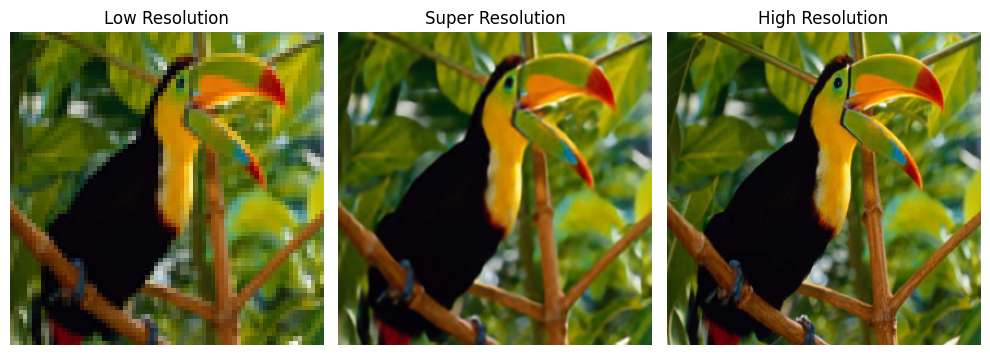

>> Size of low-res image: torch.Size([3, 64, 64])
>> Size of super-res image: torch.Size([3, 256, 256])
>> Size of high-res image: torch.Size([3, 256, 256])


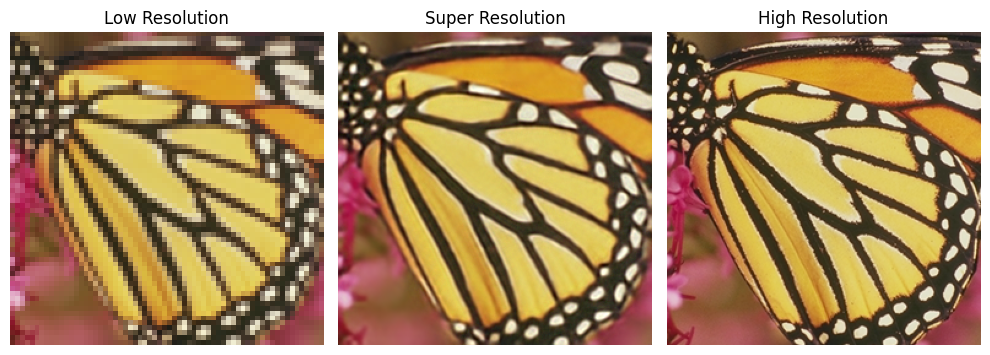

Metrics across 5 images:
> L1 Loss: 0.0226
> PSNR: 29.0489
> SSIM: 0.8476


In [56]:
SET5_PATH = "/kaggle/input/super-resolution-hust/Super Resolution HUST/Set5/image_SRF_4/"
set5_dataset = TestDataset(hr_images_path=SET5_PATH)
print(len(set5_dataset))

# Tạo dataset
test_dataset = TestDataset(SET5_PATH)

# Chạy test, hiển thị hình ảnh cho ảnh thứ 0 và 5
test_on_dataset(model, test_dataset, IDX=[0, 4])